In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from MetalCosfr_data_processing_functions import *

/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use("../../mainstyle.mplstyle")

main_dir = os.getenv('MY_PROJECT_PATH', '../')
tools_dir_path = main_dir + 'analysis'
data_path = main_dir + 'data/'

cosmic_time, redshifts, log1pz, dt = get_time_redshift_bins()

In [3]:
# Get model_names for the interesting model variation
SFMR_ref = 'P23slope08'
calib = 'C20_ADF'# 'KK04b', 'C20_ADF'
delta_FMR_ZOH_asym_0 = 0.25
evolving_low_M_slope = True
lMmin1 = 6
lMmin2 = 8
SB_ref ='Boco ' # 'Rinaldi24', 'Boco'
# SB_ref2 = 'BiC18'
OFe_ref = 'pl400CCFep1' # 'pl400CCFep1', 'pl40CCFep03', 'pl400CCFep1'

cluster_data = False 

# model_name = get_model_name(
#     SFMR_ref=SFMR_ref, calib=calib, delta_FMR_ZOH_asym_0=delta_FMR_ZOH_asym_0,
#     evolving_low_M_slope=evolving_low_M_slope, OFe_ref=OFe_ref, FMR_slope=0.27,
#     SB_ref=SB_ref, IMF_ref='K01', lMmin=lMmin1, lMmax=12., z_start=10.,
#     any_addons='None')

model_names, model_OFe_color, SB_flag = get_model_selection(
    OFe_var='all', OFe_color=['#e66101','#5e3c99','#01665e'],
    no_GSMF_fix=True, no_asfr_1=False, no_SB=True, skip_excluded_by_lGRB=True)

data_operation = "subtract model2" # Not used (but keep it there)

In [4]:
z_lower_cuts = np.arange(0, 10, 0.05)
z_upper_cuts = np.array([10. for zi in z_lower_cuts])

mass_fractions_models = {name: [] for name in model_names}
redshifts_models = {name: [] for name in model_names}

with tqdm(total=len(model_names) * len(z_lower_cuts)) as pbar:
    for model_name in model_names:
        for i, (z_upper_cut, z_lower_cut) in enumerate(zip(z_upper_cuts, z_lower_cuts)):
            _, _, _, _, _, FeH_arr, FeH_z_integral = get_data_cut_in_redshift(
                metallicity_probe="FeH",
                z_lower_cut=z_lower_cut, z_upper_cut=z_upper_cut,
                model_name=model_name, data_path=data_path,
                cosmic_time=cosmic_time, redshifts=redshifts,
                cluster_data=cluster_data, data_operation=data_operation)
                
            norm = np.sum(FeH_z_integral)
            low_met_mask = FeH_arr < -1
            low_met_mass = np.sum(FeH_z_integral[low_met_mask])
            mass_fractions_models[model_name].append(low_met_mass / norm)
            redshifts_models[model_name].append(z_lower_cut)

            pbar.update(1)

        redshifts_models[model_name] = np.array(redshifts_models[model_name])
        mass_fractions_models[model_name] = np.array(mass_fractions_models[model_name])

100%|██████████| 3000/3000 [01:04<00:00, 46.23it/s]


Pessimistic: SFR-P23-Z-C20_ADF-Zev-False-GSMFev-True-OFe-pl40CCFep03-FMR0-27-SB-Boco
Optimistic: SFR-P23slope08-Z-C20_ADF-Zev-True-GSMFev-True-OFe-pl400CCFep1-FMR0-27-SB-Boco-dFMR3_10-25


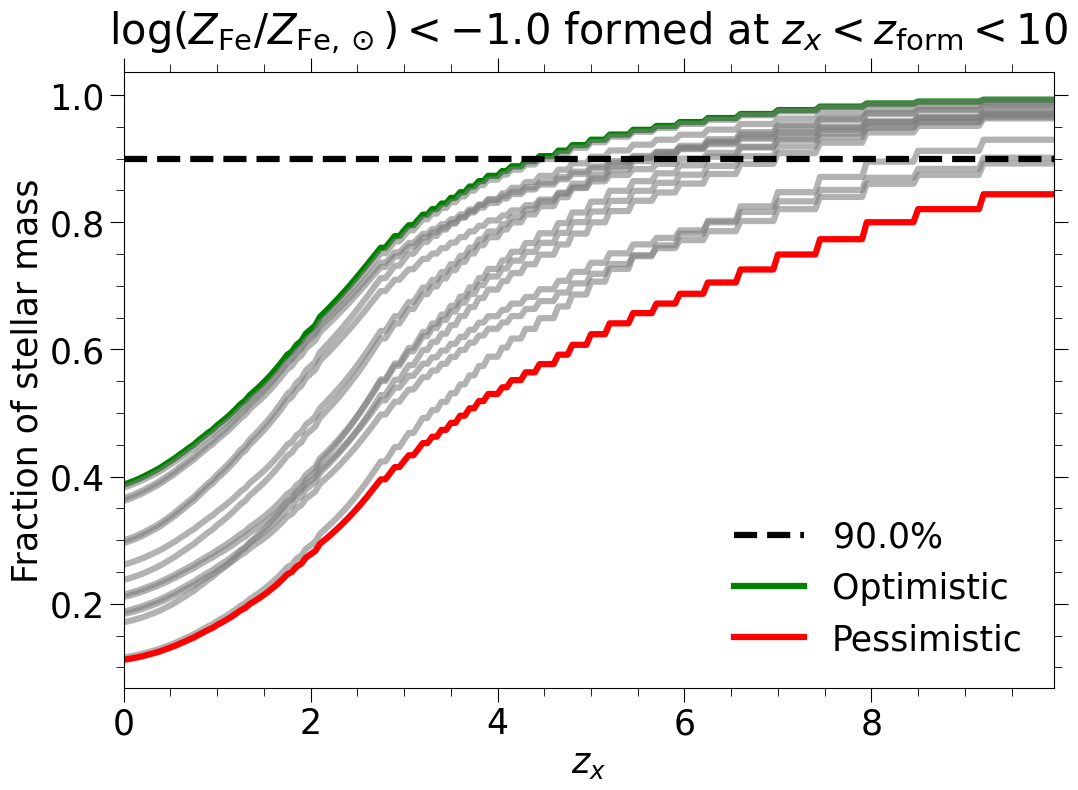

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$\log(Z_\mathrm{Fe}/Z_{\mathrm{Fe},\odot}) < -1.0$ formed at $z_x < z_\text{form} < 10$', pad=20)
ax.set_xlabel(r'$z_x$')
ax.set_ylabel('Fraction of stellar mass')

optimistic_model, pessimistic_model = model_names[5], model_names[4]
for model_name in model_names:
    if model_name == optimistic_model:
        ax.plot(redshifts_models[model_name], mass_fractions_models[model_name], color='green', label='Optimistic')
        print(f"Optimistic: {model_name}")
    elif model_name == pessimistic_model:
        ax.plot(redshifts_models[model_name], mass_fractions_models[model_name], color='red', label='Pessimistic')
        print(f"Pessimistic: {model_name}")
    else:
        ax.plot(redshifts_models[model_name], mass_fractions_models[model_name], color='gray', alpha=0.6)

for lv in (0.9,):
    ax.axhline(lv, linestyle='--', color='black', label=r'${0}\%$'.format(lv * 100))

ax.autoscale(axis='x', tight=True)

ax.legend(loc='lower right', frameon=False, reverse=True)

fig.savefig("../../paper/images/Mf_zt")

plt.show()